In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [26]:
def load_data(data_dir, img_size=(128,128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace('.jpg', '_mask.jpg'))
    
            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
    
            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
    
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)
        

In [27]:
train_dir = '/kaggle/input/unet4321/split_datasets/train'
val_dir = '/kaggle/input/unet4321/split_datasets/val'
test_dir = '/kaggle/input/unet4321/split_datasets/test'

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

In [28]:
def build_dilated_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv3)  # Dilated Convolution
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=4)(conv4)  # Dilated Convolution

    # Decoder
    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
model = build_dilated_unet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 128, 128, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 32)     │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 64)     │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 128)    │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 32, 32, 128)    │        131,200 │ conv2d_37[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 32, 32, 256)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 128)    │        295,040 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7   

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    t_true = tf.reduce_sum(y_true)
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    intersection = tf.cast(intersection, dtype=tf.float32)

    y_true = tf.reduce_sum(y_true)
    y_pred = tf.reduce_sum(y_pred)

    result = (2.0*(intersection) + smooth) / (y_true + y_pred + smooth)

    return result

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

    dice_loss_value = dice_loss(y_true, y_pred)

    return a*dice_loss_value + (1-a)*logit_loss_value

In [31]:
model.compile(optimizer='adam',
             loss = combined_loss,
             metrics=[dice_coef])

In [32]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.9,
    patience=3,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.keras',
    monitor='val_dice_coef',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [33]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, model_checkpoint])

model.save('dilated_unet_model.keras')

# Evaluate model size based on parameters
def get_model_param_size(model):
    total_params = model.count_params()
    size_in_mb = (total_params * 4) / (1024 ** 2)  # 4 bytes per parameter, converted to MB
    print(f"Model parameter size: {size_in_mb:.2f} MB")
    return size_in_mb

dilated_model_param_size = get_model_param_size(model)

# Measure inference time
def measure_inference_time(model, X_sample):
    import time
    start_time = time.time()
    model.predict(X_sample, batch_size=1)  # Set batch size to 1 for single-sample inference
    end_time = time.time()
    inference_time = (end_time - start_time) / len(X_sample)
    print(f"Inference time per sample: {inference_time:.4f} seconds")
    return inference_time

dilated_inference_time = measure_inference_time(model, X_test[:10])

print(f"Dilated Model Parameter Size: {dilated_model_param_size:.2f} MB")
print(f"Dilated Inference Time: {dilated_inference_time:.4f} seconds/sample")

Epoch 1/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dice_coef: 0.0022 - loss: 0.9650
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - dice_coef: 0.0021 - loss: 0.9648 - val_dice_coef: 1.1786e-10 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 2/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dice_coef: 1.2725e-10 - loss: 0.9569
Epoch 2: val_dice_coef did not improve from 0.00000
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - dice_coef: 1.2719e-10 - loss: 0.9569 - val_dice_coef: 1.1786e-10 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 3/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dice_coef: 0.0183 - loss: 0.9365
Epoch 3: val_dice_coef improved from 0.00000 to 0.67630, saving model to best_unet_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - dice_coef: 0.0242 - loss: 0.9309 - val_dice_coef: 0.6763 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 4/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - dice_coe

In [34]:
best_model = tf.keras.models.load_model('best_unet_model.keras', 
                                       custom_objects={'combined_loss' : combined_loss,
                                                      'dice_coef' : dice_coef})
test_loss, test_dice = best_model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - dice_coef: 0.4833 - loss: 0.4967


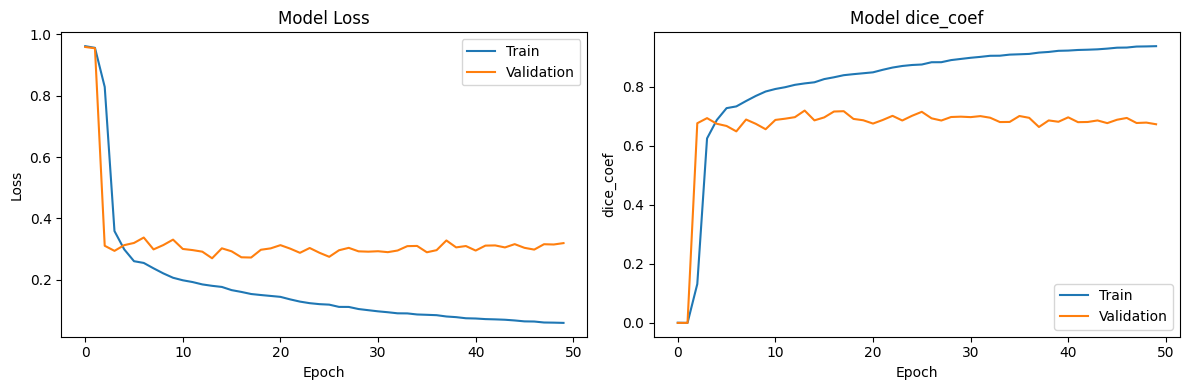

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])
    predictions = (predictions > 0.5).astype(np.float32)
    plt.figure(figsize=(4*num_samples, 12))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title(f'True Mask\nDice: {dice_coef(y[i:i+1], predictions[i:i+1]).numpy():.4f}')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_results(model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
